In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
data = pd.read_csv("data/cbb.csv")

In [24]:
data['POSTSEASON'] = data['POSTSEASON'].fillna(0)
data['SEED'] = data['SEED'].fillna(0)

In [25]:
yearly = [data[data["YEAR"] == x] for x in range(2013, 2022)]

G: Number of games played

W: Number of games won

ADJOE: Adjusted Offensive Efficiency (An estimate of the offensive efficiency (points scored per 100 possessions) a team would have against the average Division I defense)

ADJDE: Adjusted Defensive Efficiency (An estimate of the defensive efficiency (points allowed per 100 possessions) a team would have against the average Division I offense)

BARTHAG: Power Rating (Chance of beating an average Division I team)

EFG_O: Effective Field Goal Percentage Shot

EFG_D: Effective Field Goal Percentage Allowed

TOR: Turnover Percentage Allowed (Turnover Rate)

TORD: Turnover Percentage Committed (Steal Rate)

ORB: Offensive Rebound Rate

DRB: Offensive Rebound Rate Allowed

FTR : Free Throw Rate (How often the given team shoots Free Throws)

FTRD: Free Throw Rate Allowed

2P_O: Two-Point Shooting Percentage

2P_D: Two-Point Shooting Percentage Allowed

3P_O: Three-Point Shooting Percentage

3P_D: Three-Point Shooting Percentage Allowed

ADJ_T: Adjusted Tempo (An estimate of the tempo (possessions per 40 minutes) a team would have against the team that wants to play at an average Division I tempo)

WAB: Wins Above Bubble (The bubble refers to the cut off between making the NCAA March Madness Tournament and not making it)

POSTSEASON: Round where the given team was eliminated or where their season ended (R68 = First Four, R64 = Round of 64, R32 = Round of 32, S16 = Sweet Sixteen, E8 = Elite Eight, F4 = Final Four, 2ND = Runner-up, Champion = Winner of the NCAA March Madness Tournament for that given year)

SEED: Seed in the NCAA March Madness Tournament

YEAR: Season

In [26]:
data['CONF'].unique() 

array(['ACC', 'B10', 'B12', 'WCC', 'SEC', 'BE', 'Amer', 'P12', 'A10',
       'MVC', 'AE', 'ASun', 'BSky', 'BSth', 'BW', 'CAA', 'CUSA', 'Horz',
       'Ind', 'Ivy', 'MAAC', 'MAC', 'MEAC', 'MWC', 'NEC', 'OVC', 'Pat',
       'SB', 'SC', 'Slnd', 'Sum', 'SWAC', 'WAC', 'ind', 'GWC'],
      dtype=object)

In [27]:
temp = yearly[0]
confs = ["ACC", "B10", "B12", "P12", "A10", "IVY","SEC"]
temp = temp[temp['CONF'].isin(confs)]

In [28]:
temp

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
6,Michigan,B10,38,30,121.5,93.7,0.9522,54.6,48.0,14.6,...,22.7,53.4,47.6,37.9,32.6,64.8,6.2,2ND,4.0,2013
38,Ohio St.,B10,37,29,113.6,89.4,0.9406,50.6,45.4,16.2,...,29.5,49.4,43.6,35.6,32.4,65.3,7.2,E8,2.0,2013
39,Duke,ACC,36,30,118.4,91.5,0.9507,53.9,45.5,15.6,...,32.7,50.8,46.2,39.9,29.0,67.8,7.5,E8,2.0,2013
41,Florida,SEC,37,29,115.7,85.7,0.9694,55.2,43.3,17.8,...,29.9,54.3,41.8,37.8,31.0,62.8,4.1,E8,3.0,2013
1760,George Washington,A10,30,13,98.8,93.0,0.6650,46.6,47.4,23.4,...,32.7,47.7,44.6,27.9,36.0,68.0,-7.3,0,0.0,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2449,Miami FL,ACC,36,29,112.4,90.8,0.9207,51.9,45.7,16.7,...,28.3,50.6,44.0,36.2,32.6,63.0,6.3,S16,2.0,2013
2450,Michigan St.,B10,35,26,111.4,87.8,0.9392,50.6,44.5,20.8,...,32.4,50.4,44.3,34.1,30.1,64.4,6.7,S16,3.0,2013
2451,Arizona,P12,35,27,114.4,92.2,0.9229,52.5,46.6,19.5,...,32.9,50.6,43.4,37.1,35.8,66.8,4.6,S16,6.0,2013
2452,Oregon,P12,37,28,104.8,88.6,0.8728,49.3,46.4,21.4,...,33.3,49.1,44.9,33.3,33.4,69.2,2.9,S16,12.0,2013


<AxesSubplot:>

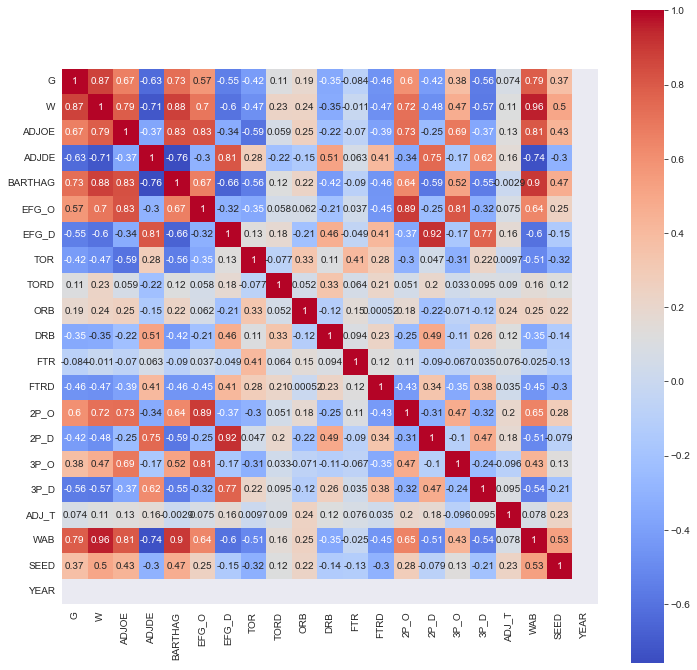

In [29]:
fig = plt.figure(figsize=(12,12))

sns.set_style('darkgrid')
sns.heatmap(temp.corr(), annot=True, square=True, cmap='coolwarm')

In [32]:
temp[temp['POSTSEASON'] != 0]

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
6,Michigan,B10,38,30,121.5,93.7,0.9522,54.6,48.0,14.6,...,22.7,53.4,47.6,37.9,32.6,64.8,6.2,2ND,4.0,2013
38,Ohio St.,B10,37,29,113.6,89.4,0.9406,50.6,45.4,16.2,...,29.5,49.4,43.6,35.6,32.4,65.3,7.2,E8,2.0,2013
39,Duke,ACC,36,30,118.4,91.5,0.9507,53.9,45.5,15.6,...,32.7,50.8,46.2,39.9,29.0,67.8,7.5,E8,2.0,2013
41,Florida,SEC,37,29,115.7,85.7,0.9694,55.2,43.3,17.8,...,29.9,54.3,41.8,37.8,31.0,62.8,4.1,E8,3.0,2013
2132,Saint Louis,A10,35,28,108.0,87.5,0.9181,50.4,45.5,17.6,...,35.0,50.0,44.1,34.0,33.1,64.7,3.8,R32,4.0,2013
2133,VCU,A10,36,27,113.8,92.1,0.9195,51.3,49.9,16.9,...,40.3,50.5,50.1,35.1,32.9,68.1,2.6,R32,5.0,2013
2134,Butler,A10,35,26,109.2,93.0,0.8624,50.7,46.7,20.2,...,36.1,50.2,45.3,34.3,33.2,64.7,4.7,R32,6.0,2013
2137,Illinois,B10,34,21,109.8,92.7,0.8749,47.5,48.7,17.6,...,36.0,47.4,47.4,31.7,34.1,66.1,2.4,R32,7.0,2013
2140,North Carolina,ACC,35,24,111.6,93.0,0.8902,49.3,48.0,17.2,...,27.1,46.3,46.3,37.2,34.4,71.4,2.5,R32,8.0,2013
2141,Temple,A10,34,24,110.7,96.9,0.8220,49.0,49.0,15.9,...,34.1,48.8,47.3,32.8,35.3,66.8,1.5,R32,9.0,2013
